
From our Navier-Stokes equation: 
\begin{equation}
\frac{\partial u}{\partial t} = -\Delta P + \eta \Delta^2 u - \gamma P u
\end{equation}

Where P is pressure, \eta is a viscosity, and u is a fluid velocity, we can apply \textbf{Chorin's projection method} to solve the system numerically. The basic steps of Chorin's method are:

1) Compute intermediate velocity, $u^*$

2) Solve poisson eqn to get P

3) Correct the intermediate velocity to find $u_{(n+1)}$




Reference: 

https://math.berkeley.edu/~chorin/chorin68.pdf

https://www3.nd.edu/~gtryggva/CFD-Course/2011-Lecture-22.pdf

The expression for the Magnetic field is

$$ \vec F = q \vec v \times \vec B$$
$$ = q ( v_x, v_y, 0) \times (0, 0, B) $$
$$= qB (v_x \hat x \times \hat z) + qB( v_y \hat y \times \hat z)$$
$$ = qB( -v_x \hat y + v_y \hat x) $$
Assuming we're working with an electron which has charge $-e$,
$$ = -eB( v_y, - v_x)$$
$$ = B(-v_y, v_x)$$

Which is a body force that couples the two directions of momentum. We can find the contribution to the $v_x$ and $v_y$ component simply by adding in this coupling term which occurs in the same cell. Working from the equation of motion

$$ \partial_t \vec v = -A \vec v + \nu \nabla^2 \vec v + \frac{qB}{\rho} (\vec v \times \vec B)$$
$$ \partial_t \vec v = - A \vec v + \nu \nabla^2 \vec v + \bar B (-v_y, v_x)$$
where $\bar B = \frac{|e|B}{\rho}$.

In [16]:
# IMPORT STATEMENTS

import numpy as np
from scipy import misc, fftpack
import os
import matplotlib.pyplot as plt
import time

The discrete time-evolution step is as follows:

$$ v_x^* = v^x_{i,j}+ \Delta t \left[ -\frac{1}{4 \Delta x} \left( (v^x_{i+1,j} + v^x_{i,j})^2 - (v^x_{i,j} + v^x_{i-1,j})^2 + (v^x_{i,j+1} + v^x_{i,j})(v^y_{i+1,j} + v^y_{i,j}) - (v^x_{i,j} + v^x_{i,j-1})(v^y_{i+1,j-1} +v^y_{i,j-1}  \right) \right) + \Delta t \frac{\nu}{\Delta x^2}  \left(v^x_{i+1,j} + v^x_{i-1,j} + v^x_{i,j+1} + v^x_{i,j-1} - 4 v^x_{i,j} ) \right]$$ 


$$ v_y^* = v^y_{i,j}+ \Delta t \left[ -\frac{1}{4 \Delta x} \left( (v^y_{i,j+1} + v^y_{i,j})^2   - (v^y_{i,j} + v^y_{i,j-1})^2 +  (v^x_{i,j+1} + v^x_{i,j})(v^y_{i+1,j} + v^y_{i,j}) - (v^x_{i-1,j+1} + v^x_{i-1,j} )( v^y_{i,j} + v^y_{i-1,j}) \right)  + \Delta t  \frac{\nu}{(\Delta x)^2} \left( v^y_{i+1,j} + v^y_{i-1,j} + v^y_{i,j+1} + v^y_{i,j-1} - 4 v^y_{i,j} \right) \right]
$$

The first term (prefactored by $ \frac{\Delta t}{4 \Delta x}$) is identified with the advective flow/the material derivative.

The second term (prefactored by $\frac{\Delta t \nu}{(\Delta x)^2}$) is identified with the viscous flow and 'conduction' of velocity across neighboring cells.

In [17]:
# BOTH OF THESE MAY NEED MODIFYING TO HANDLE BODY FORCES

# ==================================================
# GET INTERMEDIATE VELOCITY (u*) STEP 
# ==================================================
def vel_temps(dt,dx,v,nx,ny,ux,uy,ux_star,uy_star,Bbar=0):
    
    # get ux*
    for i in range(1,nx): 
        for j in range(1,ny+1):
            ux_star[i,j]=ux[i,j] \
                         + dt*(-(0.25/dx)*((ux[i+1,j]+ux[i,j])**2
                         -(ux[i,j]+ux[i-1,j])**2
                         +(ux[i,j+1]+ux[i,j])*(uy[i+1,j]+uy[i,j])
                         -(ux[i,j]+ux[i,j-1])*(uy[i+1,j-1]+uy[i,j-1]))
                         +(v/dx**2)*(ux[i+1,j]+ux[i-1,j]+ux[i,j+1]
                         +ux[i,j-1]-4*ux[i,j])) - dt*Bbar*uy[i,j]
    # get uy*
    for i in range(1,nx+1):
        for j in range(1,ny): 
            uy_star[i,j]=uy[i,j]\
                         +dt*(-(0.25/dx)*((ux[i,j+1]+ux[i,j])*(uy[i+1,j]+uy[i,j])
                         -(ux[i-1,j+1]+ux[i-1,j])*(uy[i,j]+uy[i-1,j])
                         +(uy[i,j+1]+uy[i,j])**2-(uy[i,j]+uy[i,j-1])**2)
                         +(v/dx**2)*(uy[i+1,j]+uy[i-1,j]
                         +uy[i,j+1]+uy[i,j-1]-4*uy[i,j])) +dt*Bbar*ux[i,j]
    return ux_star, uy_star

# ==================================================
# SOLVE POISSON EQUATION TO GET PRESSURE -- borrowed from another code! should likely be replaced
# Somewhat slow at current, I think -- perhaps should find a library function for this? 
# ==================================================
def poisson(dt,dx,nx,ny,b,c,ux_temp,uy_temp,p):

    E = 1; T = 5e-6    # error and tolerance cutoffs
    itmax = 200        # don't let it run too long ... 
    p_prev = p
    for it in range(itmax): 
        for i in range(1,nx+1): 
            for j in range(1,ny+1):
                p[i,j] = b*c[i,j]*( p[i+1,j]+p[i-1,j]+p[i,j+1]+p[i,j-1]
                         -(dx/dt)*(ux_temp[i,j]-ux_temp[i-1,j]+uy_temp[i,j]-uy_temp[i,j-1]))\
                         +(1-b)*p[i,j]
        E = np.max( abs( p - p_prev ) ) 
        p_prev = p
        if E < T:  break 
    return p


In [20]:
def projection(Bbar):
    
    # GRID PARAMETERS ===========================================================
    lx = 1.0                      # x length dimension
    ly = 2.0                      # y length dimension
    gridres = 100
    nx = int(gridres*lx)          # x grid resolution
    ny = int(gridres*ly)          # y grid resolution  
    dx = lx/nx         

    X,Y = np.meshgrid(np.linspace(0,lx,nx),np.linspace(0,ly,ny))
    
    # SIMULATION PARAMETERS =====================================================
    mu = 5.           # dynamic viscosity (kg / m*s)
    rho = 1000.       # Fluid density (kg/m^3) 
    v=mu/rho          # kinematic viscosity
    b=1.25            # relaxation? 

    # INITIALIZE ARRAYS =========================================================
    ux=np.zeros((nx+1,ny+2))        # x vel
    uy=np.zeros((nx+2,ny+1))        # y vel
    p=np.zeros((nx+2,ny+2))         # pressure 
    ux_star=np.zeros((nx+1,ny+2))   # u*
    uy_star=np.zeros((nx+2,ny+1))   # v*

    # part of my borrowed poisson solving .... again, maybe replce this with a library function? 
    c=1/4*np.ones((nx+2,ny+2))  # interior
    c[1,2:ny-1]=1/3             # boundary 
    c[nx,2:ny-1]=1/3            # boundary 
    c[2:nx-1,1]=1/3             # boundary 
    c[2:nx-1,ny]=1/3            # boundary 
    c[1,1]=1/2                  # corner
    c[1,ny]=1/2                 # corner 
    c[nx,1]=1/2                 # corner 
    c[nx,ny]=1/2                # corner 

    # BOUNDARY CONDTIONS 
    U = 1.0                # reference velocity 
    xnorth = U             # injects with some reference velocity at the beginning of every time step
    xsouth = 0.0          
    yright = 0.0
    yleft = 0.0
    uy = U*np.ones((nx+2,ny+1))  # y vel initialized to a constant --- obviously can be changed and played with
    nsteps = 500
    dt = 0.00125                # perhaps better to calculate this somehow, rather than make a guess? 
    
    # Print info
    print_num = 30      # print every this many steps

    # TIME STEPPING ================================================
    for j in range(1,nsteps+1):
        
        t = j*dt
        
        # these are some BCs -- totally should be changed and updated 
        # boundary conditions ---> currently, this is borrowed from another code... 
        # someone should try to implement PBCs 
        
        ux[0:nx,:] = (ux[0:nx,:] + xnorth )* np.tanh(2.5*t)    # for example, I've played with this to show fluid being 
                                                               # injected from the top --- would be better to have it 
                                                               # stream around the side 
        #ux[0:nx,0]   = ( 2*xnorth-ux[0:nx,1]  )  * np.tanh(2.5*t)
        ux[0:nx,ny+1] = ( 2*xsouth-ux[0:nx,ny] )  * np.tanh(2.5*t)
        uy[0,0:ny]   = ( 2*yleft-uy[1,0:ny] )  * np.tanh(2.5*t)
        uy[nx+1,0:ny]= ( 2*yright-uy[nx,0:ny] )* np.tanh(2.5*t)

        for k in range(0,3):

            # calculate temporary velocity fields 
            ux_star, uy_star = vel_temps(dt,dx,v,nx,ny,ux,uy,ux_star,uy_star)

            # solve Poisson eqn for pressure? 
            p = poisson(dt,dx,nx,ny,b,c,ux_star,uy_star,p)

            # repair velocity 
            ux[1:nx-1,1:ny] = ux_star[1:nx-1,1:ny] - (dt/dx) * ( p[2:nx,1:ny] - p[1:nx-1,1:ny] )
            uy[1:nx,1:ny-1] = uy_star[1:nx,1:ny-1] - (dt/dx) * ( p[1:nx,2:ny] - p[1:nx,1:ny-1] )
        
        # Check how the simulation is going 
        if ( j % print_num == 0):
            
            # save images to make the video
            plt.imshow(ux)     # currently this is just plotting the y velocity field. 
                               # maybe we would like more than this? 
            #plt.savefig('./' + "/file%02d.png" % j)    # uncomment this if you will try to make a movie afterwards
            plt.show()
            


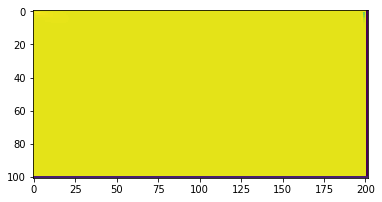

KeyboardInterrupt: 

In [22]:
# RUN THE CODE HERE
# the general method is good I think -- needs to have some modification to match our needs 
# in terms of forces, geometry, BCs.... etc. 
start = time.time()

projection(0)

end = time.time()
print(end - start)

In [ ]:
# DOES NOT WORK WELL PRESENTLY -- fix if you can!
# It should be reading in the images output by the main code, and then formatting them into a video
# if remove section at the bottom is uncommented, it will also clean up all the left over image files

# This requires ffmpeg, which can be installed by following the instructions here: 
# http://www.renevolution.com/ffmpeg/2013/03/16/how-to-install-ffmpeg-on-mac-os-x.html

import glob
import os
import subprocess

def generate_video():

    subprocess.call([
        'ffmpeg', '-framerate', '5', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'vid.mp4'
    ])
    #for file_name in glob.glob("*.png"):
        #os.remove(file_name)

generate_video()